<a href="https://colab.research.google.com/github/jcjr64/CIND820/blob/main/Codes/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas pdfplumber beautifulsoup4 requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 56.9 MB/s eta 0:00:00


In [ ]:
import pdfplumber
import pandas as pd
import glob
import re
from dateutil.parser import parse

In [ ]:
#Loading the Loughran-McDonald Master Dictionary

lm_dict = pd.read_csv('/content/Dict/Loughran-McDonald_MasterDictionary_1993-2021 (1).csv')
positive_words = lm_dict[lm_dict['Positive'] > 0]['Word'].str.lower().tolist()
negative_words = lm_dict[lm_dict['Negative'] > 0]['Word'].str.lower().tolist()

In [ ]:
def extract_date_from_filename(file_name):
    date_pattern = '\d{4}-\d{2}-\d{2}'  # Adjust based on your file naming convention
    match = re.search(date_pattern, file_name)
    if match:
        return parse(match.group(0)).date()
    return None

In [ ]:
def parse_pdf(file_path):
    text = ''
    with pdfplumber.open(file_path) as pdf:
        for page in pdf.pages:
            text += page.extract_text() or ''
    return text

In [ ]:
def analyze_sentiment(text):
    words = text.lower().split()
    pos_count = sum(word in positive_words for word in words)
    neg_count = sum(word in negative_words for word in words)
    return pos_count - neg_count  # Simple sentiment score: positive - negative

In [ ]:
def process_pdfs_in_directory(directory_path):
    results = []

    for file_path in glob.glob(f"{directory_path}/*.pdf"):
        file_name = file_path.split('/')[-1]
        date = extract_date_from_filename(file_name)
        text = parse_pdf(file_path)
        sentiment_score = analyze_sentiment(text)

        results.append({
            'file_name': file_name,
            'date': date,
            'sentiment_score': sentiment_score,
            'average_sentiment_score': sentiment_score  # Since we're treating the entire PDF as a single unit
        })

    return results

In [ ]:
pdf_directory = '/content/SECdated'  # Replace with the actual path to your PDF files
pdf_results = process_pdfs_in_directory(pdf_directory)

# Display the results
for result in pdf_results:
    print(f"File: {result['file_name']}, Date: {result['date']}, Average Sentiment Score: {result['average_sentiment_score']}")

File: 2020-09-30.pdf, Date: 2020-09-30, Average Sentiment Score: -38
File: 2022-08-16.pdf, Date: 2022-08-16, Average Sentiment Score: 0
File: 2023-09-28.pdf, Date: 2023-09-28, Average Sentiment Score: -147
File: 2021-06-11.pdf, Date: 2021-06-11, Average Sentiment Score: -146
File: 2020-09-25.pdf, Date: 2020-09-25, Average Sentiment Score: -105
File: 2021-07-14.pdf, Date: 2021-07-14, Average Sentiment Score: -41
File: 2022-09-29.pdf, Date: 2022-09-29, Average Sentiment Score: -116
File: 2022-12-14.pdf, Date: 2022-12-14, Average Sentiment Score: -188
File: 2022-08-01.pdf, Date: 2022-08-01, Average Sentiment Score: -193
File: 2023-06-05.pdf, Date: 2023-06-05, Average Sentiment Score: -199
File: 2017-07-25.pdf, Date: 2017-07-25, Average Sentiment Score: -50
File: 2018-09-11 (2).pdf, Date: 2018-09-11, Average Sentiment Score: -47
File: 2022-11-04.pdf, Date: 2022-11-04, Average Sentiment Score: -139
File: 2021-09-01.pdf, Date: 2021-09-01, Average Sentiment Score: -224
File: 2023-01-12.pdf, D

In [ ]:
import pandas as pd

# Load Bitcoin prices
btc_prices = pd.read_csv('/content/BTC-USD/BTC-USD (1).csv', usecols=['Date', 'Close'], parse_dates=['Date'])
btc_prices.set_index('Date', inplace=True)

In [ ]:
# Convert PDF sentiment results to DataFrame
pdf_sentiments = pd.DataFrame(pdf_results)
pdf_sentiments['date'] = pd.to_datetime(pdf_sentiments['date'])  # Ensure 'date' is datetime type
pdf_sentiments.set_index('date', inplace=True)

# Merge sentiment scores with Bitcoin prices
merged_data = btc_prices.join(pdf_sentiments['average_sentiment_score']).fillna(0)  # Fill missing sentiment scores with 0

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Feature Engineering (example: using only 'Close' price and 'average_sentiment_score' as features)
X = merged_data[['Close', 'average_sentiment_score']].values
y = merged_data['Close'].values

# Data normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshaping data for CNN input
X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# CNN Model
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Model Training
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Model Evaluation
model.evaluate(X_test, y_test)


Epoch 1/100
87/87 [==============================] - 1s 5ms/step - loss: 498178464.0000 - val_loss: 535549248.0000
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 497362400.0000 - val_loss: 533669504.0000
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 493324800.0000 - val_loss: 526196128.0000
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 481633600.0000 - val_loss: 508367008.0000
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 459092864.0000 - val_loss: 478150976.0000
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 424152864.0000 - val_loss: 435291488.0000
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 378111040.0000 - val_loss: 380834592.0000
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 322716800.0000 - val_loss: 318251040.0000
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 2619918

10794.9423828125

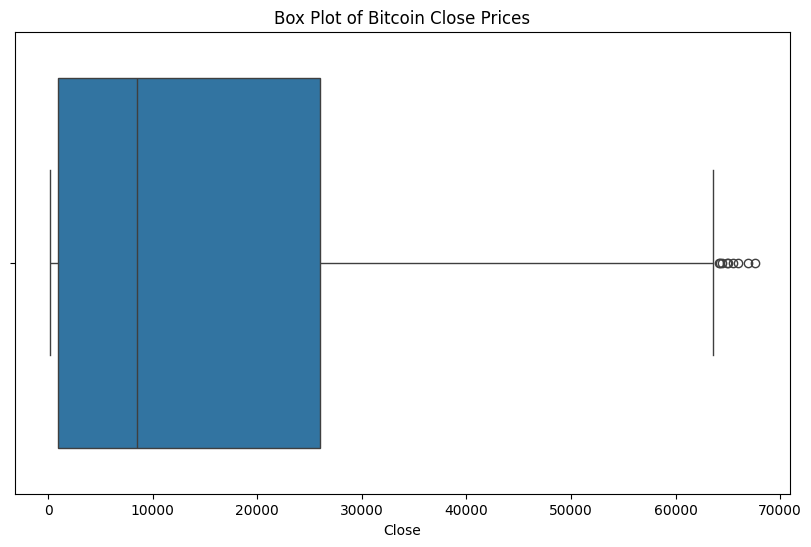

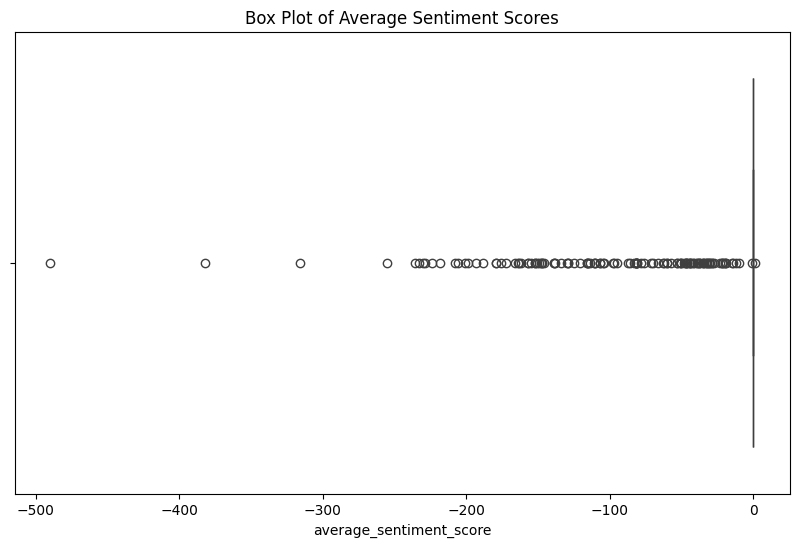

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Box plot for 'Close' prices
plt.figure(figsize=(10, 6))
sns.boxplot(x=merged_data['Close'])
plt.title('Box Plot of Bitcoin Close Prices')
plt.show()

# Box plot for 'average_sentiment_score'
plt.figure(figsize=(10, 6))
sns.boxplot(x=merged_data['average_sentiment_score'])
plt.title('Box Plot of Average Sentiment Scores')
plt.show()


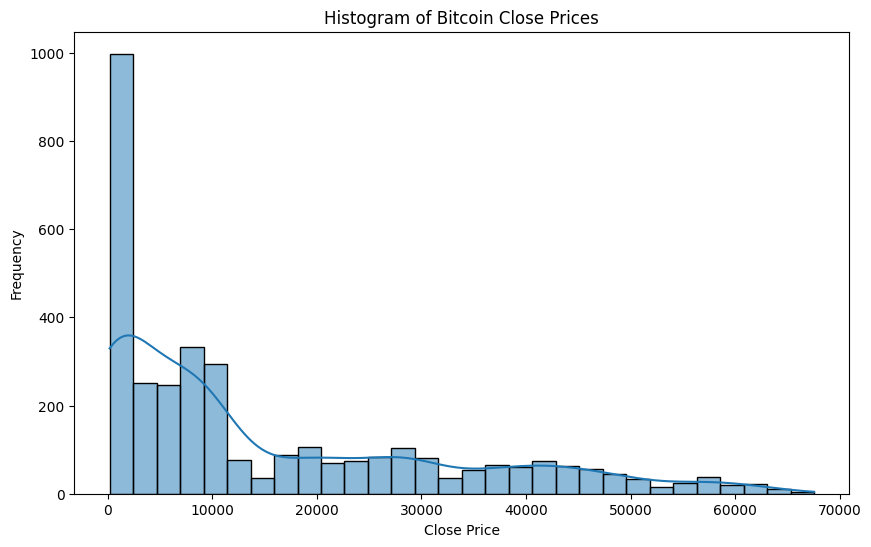

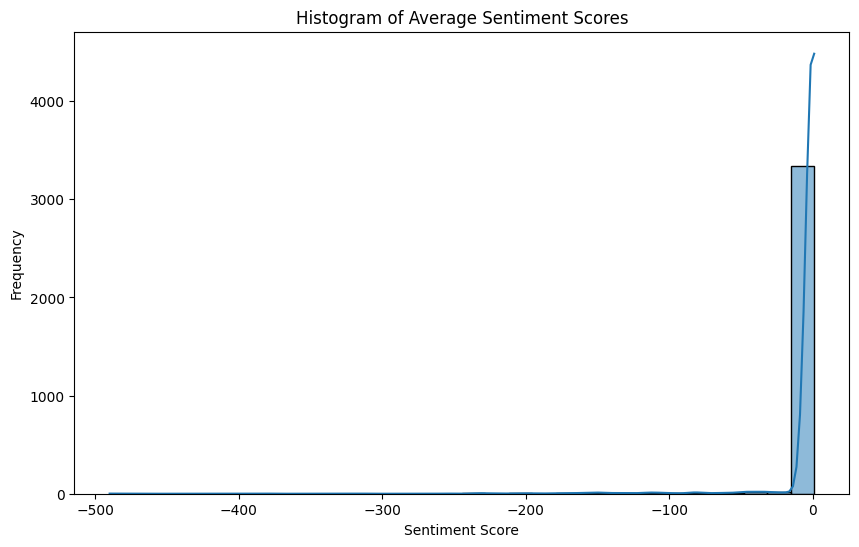

In [ ]:
# Histogram for 'Close' prices
plt.figure(figsize=(10, 6))
sns.histplot(merged_data['Close'], kde=True, bins=30)
plt.title('Histogram of Bitcoin Close Prices')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.show()

# Histogram for 'average_sentiment_score'
plt.figure(figsize=(10, 6))
sns.histplot(merged_data['average_sentiment_score'], kde=True, bins=30)
plt.title('Histogram of Average Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()


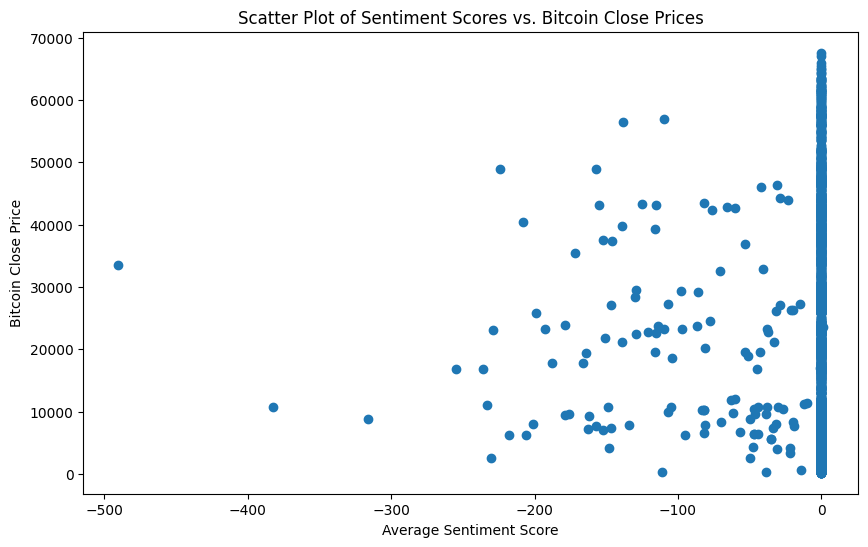

Correlation coefficient between Bitcoin Close Prices and Average Sentiment Scores: -0.05186161064100914


In [ ]:
# Scatter plot to visualize potential correlation
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['average_sentiment_score'], merged_data['Close'])
plt.title('Scatter Plot of Sentiment Scores vs. Bitcoin Close Prices')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Bitcoin Close Price')
plt.show()

# Compute and print correlation coefficient
correlation = merged_data['Close'].corr(merged_data['average_sentiment_score'])
print(f"Correlation coefficient between Bitcoin Close Prices and Average Sentiment Scores: {correlation}")


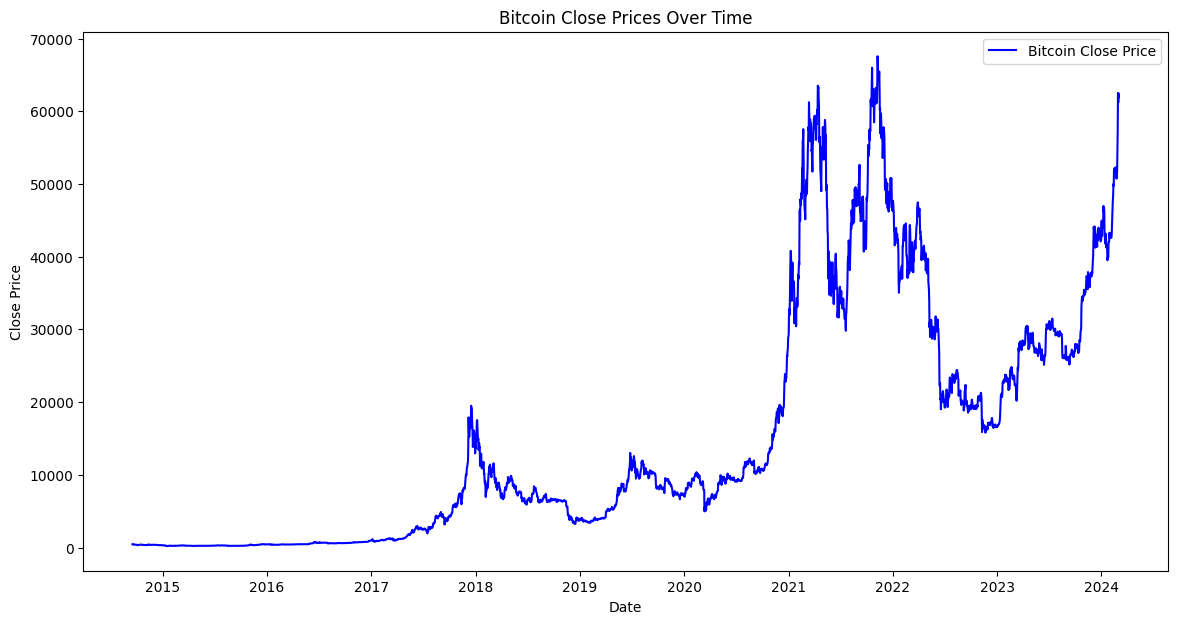

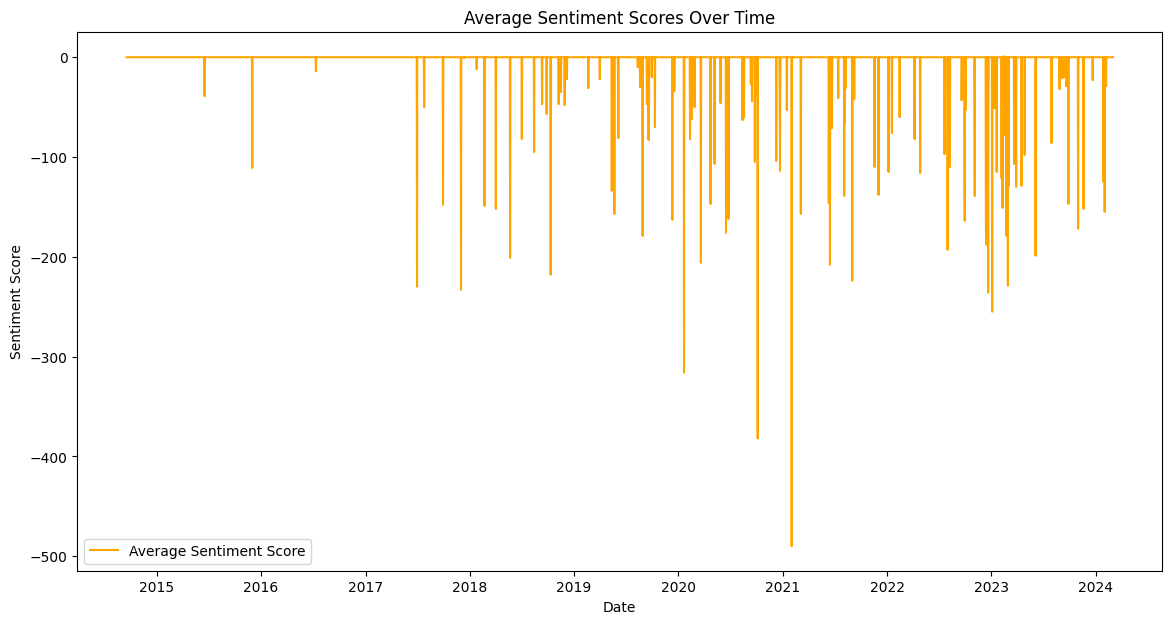

In [ ]:
# Time Series plot for 'Close' prices
plt.figure(figsize=(14, 7))
plt.plot(merged_data.index, merged_data['Close'], label='Bitcoin Close Price', color='blue')
plt.title('Bitcoin Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Time Series plot for 'average_sentiment_score'
plt.figure(figsize=(14, 7))
plt.plot(merged_data.index, merged_data['average_sentiment_score'], label='Average Sentiment Score', color='orange')
plt.title('Average Sentiment Scores Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.show()


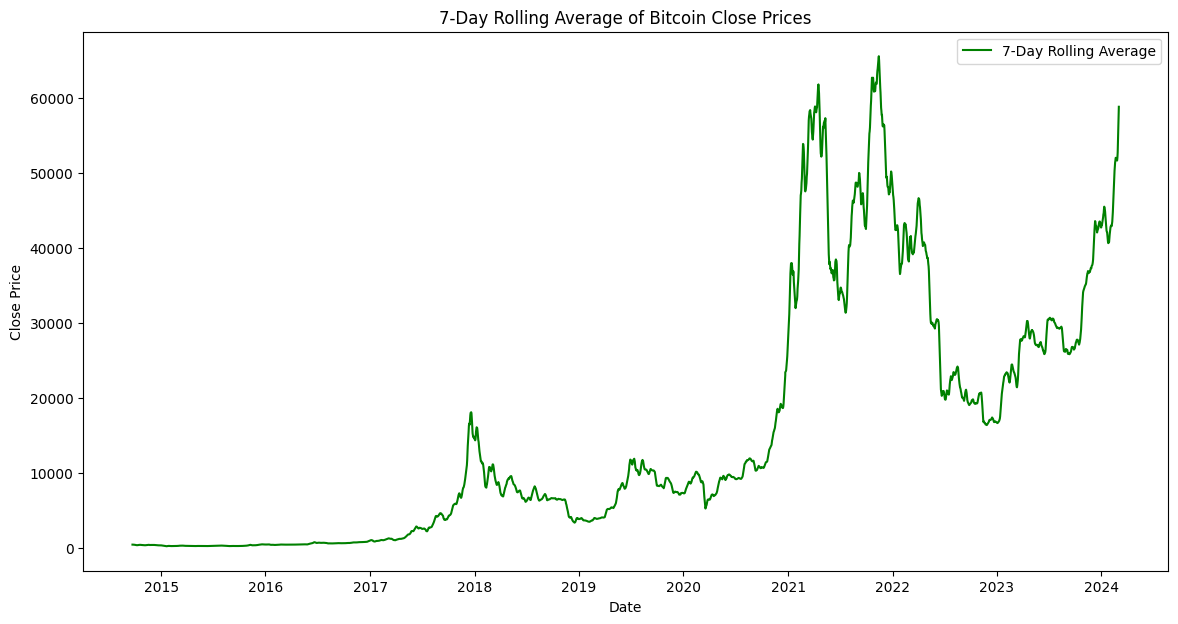

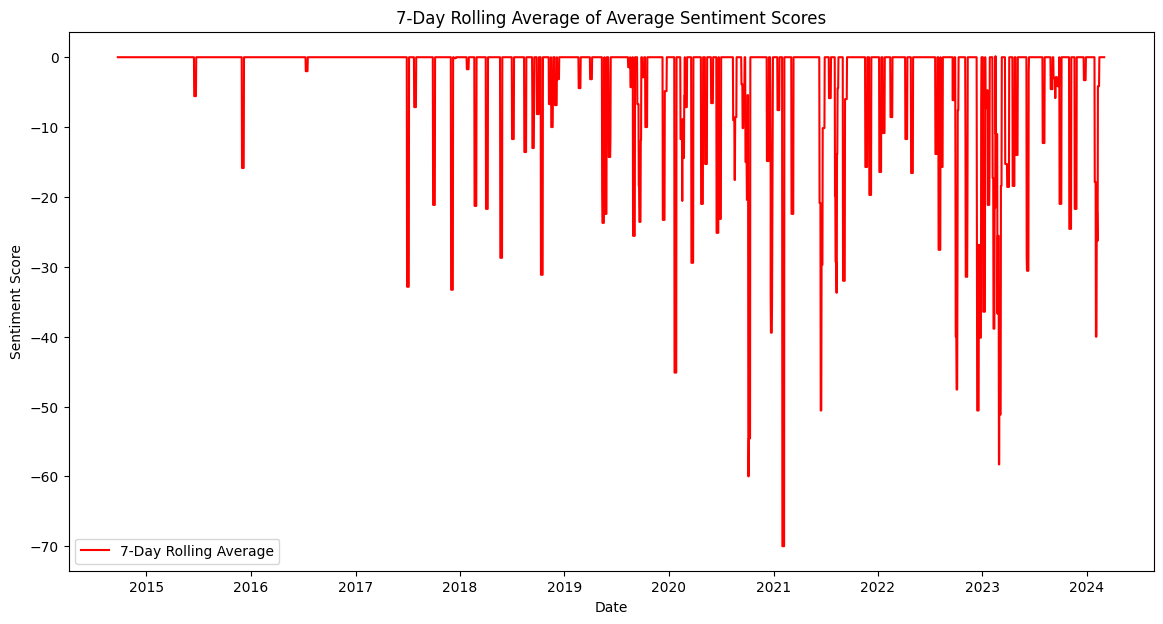

In [ ]:
# 7-day Rolling Average for 'Close' prices
plt.figure(figsize=(14, 7))
plt.plot(merged_data.index, merged_data['Close'].rolling(window=7).mean(), label='7-Day Rolling Average', color='green')
plt.title('7-Day Rolling Average of Bitcoin Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# 7-day Rolling Average for 'average_sentiment_score'
plt.figure(figsize=(14, 7))
plt.plot(merged_data.index, merged_data['average_sentiment_score'].rolling(window=7).mean(), label='7-Day Rolling Average', color='red')
plt.title('7-Day Rolling Average of Average Sentiment Scores')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.show()


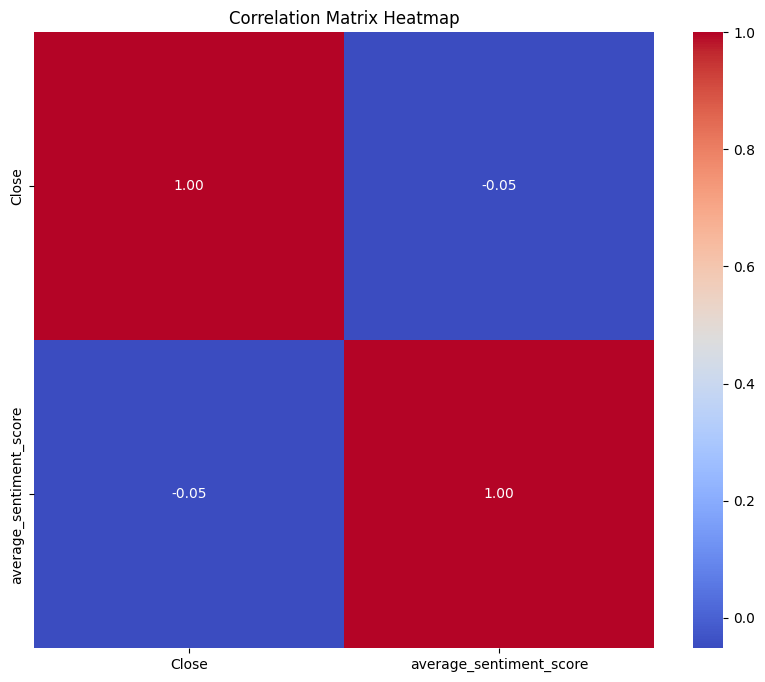

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(merged_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()



In [ ]:
# Assuming 'model' is your trained model and 'X_test' is your test set features
y_pred = model.predict(X_test)

22/22 [==============================] - 1s 5ms/step


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")



Mean Squared Error: 10794.941923225697
Root Mean Squared Error: 103.89870992089217


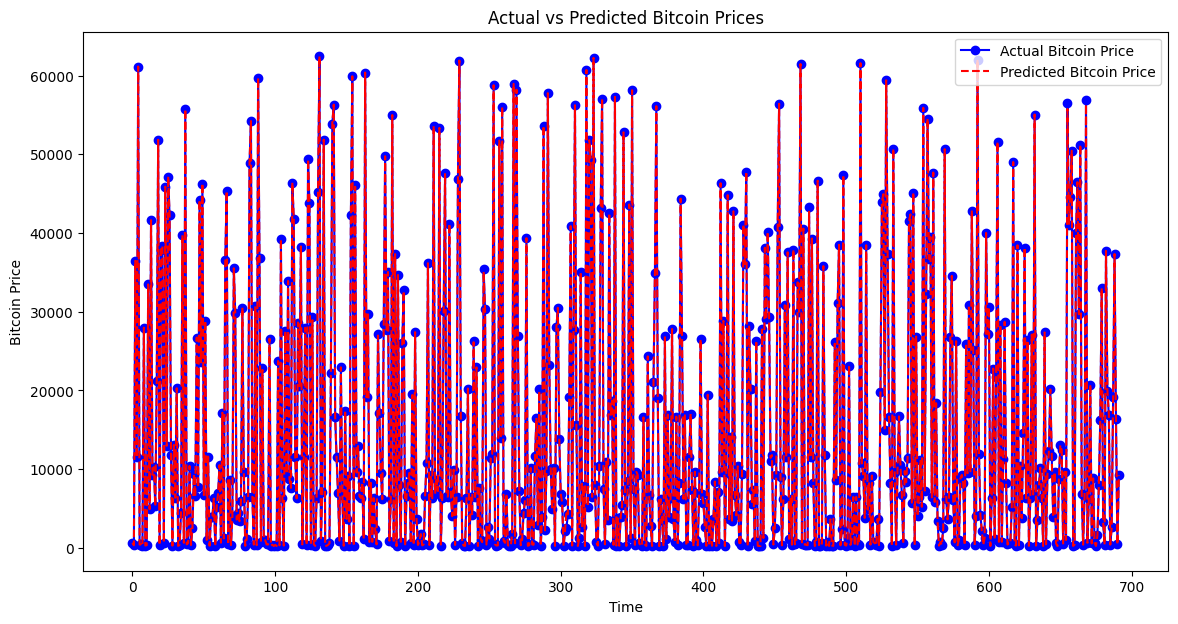

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))  # Set the figure size for better readability
plt.plot(y_test, label='Actual Bitcoin Price', color='blue', marker='o')  # Plot the actual prices
plt.plot(y_pred, label='Predicted Bitcoin Price', color='red', linestyle='--')  # Plot the predicted prices

plt.title('Actual vs Predicted Bitcoin Prices')  # Add a title to the plot
plt.xlabel('Time')  # Label for the X-axis
plt.ylabel('Bitcoin Price')  # Label for the Y-axis
plt.legend()  # Add legend to explain which line is which
plt.show()  # Display the plot
